In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

In [4]:
def pickle_reader(path):
    emb_input = pd.read_pickle(path)
    return emb_input

def reformat_pickle(emb_input):
    """Change every dash (-) by underscore to allow datasets merging"""
    
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v
        
    return reformatted_emb

def reformat_df(ORF2_counts):
    """Change every dash (-) and dot (.) by underscore (_) to allow datasets merging"""
    
    reformatted_counts_dict = {}
    counts = ORF2_counts['Non_redundant']
    names = ORF2_counts['ID']
    for i in range(len(ORF2_counts)):
        number = counts[i]
        ID = names[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        #print(clean)
        reformatted_counts_dict[clean] = number
        #reformatted_counts_dict
    
    reformatted = pd.DataFrame.from_dict(reformatted_counts_dict, orient='index')
    reformatted_counts = reformatted.reset_index()
    reformatted_counts.columns = ['ID', 'Non_redundant']
    
    return reformatted_counts
    
def pickle_to_matrix(reformatted_emb):    # Reading pickle file containing embeddings
    matrix_inverted = pd.DataFrame(reformatted_emb)  # Create df from emb dict
    matrix = matrix_inverted.transpose()  # Invert rows and columns to make it fit for Anndata object
    #matrix.index = ["dimension" + str(i) for i in range(1, matrix.shape[0]+1)]  # dimension as rows, each entry as a column
    
    return matrix 

def match_ID(matrix, reformatted_counts):
    """Matching matrix (embs) and IDs from counts file to use embs observations with counts associated (all)"""
    
   #matched_IDs = matrix.loc[:, matrix.index.isin(reformatted_counts["ID"].values)]
    matched_emb = matrix.loc[matrix.index.isin(reformatted_counts['ID'].values)]
    matched_counts = reformatted_counts.loc[reformatted_counts['ID'].isin(matrix.index)]
    counts_array = np.array(matched_counts['Non_redundant'])

    
    return matched_emb, counts_array

def extract_dimension(matched_emb):
    """Extract PC weights with sklearn (from embeddings file) and return component with highest weight"""
    
    pca = PCA()  # Define PCA function
    my_pca = pca.fit_transform(matched_emb)   # Scale data and apply PCA on embeddings df
    dataframe_pca = pd.DataFrame(my_pca)  # Convert to df
    
    df_pca_loadings = pd.DataFrame(pca.components_) # Show Principal Components Weights (Eigenvectors) for every dimension
    a = df_pca_loadings.describe()    # Print mean of every dimension weight (column) for all sequences 
    best_dimension = a.iloc[1].idxmax(axis=1)  # Extract highest mean value among all dimensions
    dimension_array = np.array(df_pca_loadings[best_dimension+1])  # Retrieve dimension value for every sequence (column indexing starts with 0)
    
    return dimension_array


**Reading files and merging**

In [5]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/embeddings_v2.pickle'
emb_input = pickle_reader(path)
reformatted_emb = reformat_pickle(emb_input)
#reformatted_emb

In [6]:
# -- Read ORF2_counts file and reformat to remove dash and dots by underscore
path_counts = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/ORF2p_counts.csv'
ORF2_counts = pd.read_csv(path_counts)
reformatted_counts = reformat_df(ORF2_counts)
#reformatted_counts

In [7]:
# -- Creating matrix from reformatted_emb dict and filtering counts and emb dataset to same length
matrix = pickle_to_matrix(reformatted_emb)
#matrix
matched_emb = match_ID(matrix, reformatted_counts)[0]
#matched_emb
#matched_counts = match_ID(matrix, reformatted_counts)[1]
#matched_counts

In [ ]:
print(len(matrix.index), len(matched_emb.index), len(matched_counts.index))  # Test number of matchs between datasets

In [18]:
matched_emb.shape

(720, 1024)

**Extracting PC weights (loadings) with sklearn (from embeddings file)**

In [19]:
dimension_array = extract_dimension(matched_emb)
X = dimension_array.reshape(-1,1)
X.shape

array([-0.00168625, -0.02031933,  0.04143126,  0.06644992,  0.05290947,
       -0.05912785, -0.00905503, -0.04693041, -0.00733922,  0.0036309 ,
        0.0480717 ,  0.05098446, -0.00125069,  0.03401736,  0.01718287,
        0.04483273,  0.01617949,  0.01798893,  0.03922728, -0.00206607,
       -0.00761671,  0.03176487, -0.00946022, -0.04054015,  0.01053592,
       -0.01932068,  0.01445481,  0.04183023, -0.01828918,  0.06625762,
        0.01610267, -0.0011192 , -0.00807835, -0.02793122,  0.03794137,
        0.02261639, -0.01254015,  0.00981117, -0.02304997,  0.03967946,
       -0.01535823, -0.01891427, -0.00232152,  0.03537039, -0.04506485,
        0.02045383,  0.02156671,  0.03381547,  0.02022549, -0.00219986,
        0.0308005 ,  0.00018438, -0.0028065 ,  0.02894531,  0.00788009,
       -0.04607819,  0.04224192,  0.00455411, -0.01444363, -0.00082537,
        0.00689791, -0.01688863, -0.02916647,  0.01410681,  0.02327239,
       -0.00036337,  0.02195083, -0.00684829,  0.0006586 ,  0.02

In [30]:
counts_array = match_ID(matrix, reformatted_counts)[1]
y = counts_array.reshape(-1,1)   #-1 as segundo argument in reshape infer the number of features
y.shape

array([[ 114873],
       [  11129],
       [  17500],
       [  21747],
       [  32089],
       [  18798],
       [  24264],
       [  17972],
       [  14925],
       [   9575],
       [  11628],
       [ 176045],
       [   4347],
       [    824],
       [     72],
       [     59],
       [     43],
       [    108],
       [    427],
       [    251],
       [    291],
       [    114],
       [    505],
       [     48],
       [    238],
       [    296],
       [    134],
       [  16689],
       [   4583],
       [   4421],
       [   4855],
       [   2413],
       [   3904],
       [   8403],
       [    242],
       [   4934],
       [   1650],
       [   9960],
       [   2926],
       [   2294],
       [   4829],
       [   2347],
       [   1113],
       [   4924],
       [    642],
       [    818],
       [    948],
       [   7414],
       [   4396],
       [    424],
       [   2211],
       [   1145],
       [   1332],
       [   7001],
       [   3707],
       [  

**Performing linear regression**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)  # split dataset

In [25]:
regr = LinearRegression()   # Define model

In [26]:
regr.fit(X_train, y_train)   # Fit linear model

LinearRegression()

In [27]:
print(regr.score(X_test, y_test))   # The best possible score is 1.0

-0.0006342600794913


In [34]:
regr.get_params(deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

**Exploring results**

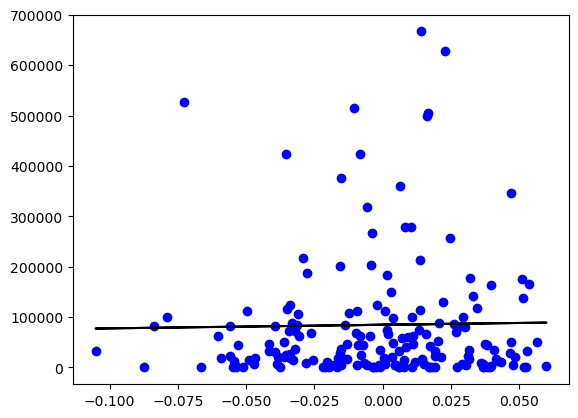

In [29]:
y_pred = regr.predict(X_test)     # Predict counts for X_test subset
plt.scatter(X_test, y_test, color = 'b')
plt.plot(X_test,y_pred, color='k')
plt.show()